In [1]:
import pandas as pd 
from collections import Counter
import string
import scipy as np
from tqdm import tqdm
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from random import randint
import time
import re
import time
import warnings 
import pickle
warnings.filterwarnings('ignore')

import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plt_dynamic(x, vy, ty, ax, colors=['b'], save=False):
    ax.clear()
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    plt.pause(1)
    fig.canvas.draw()
    if save:
        plt.save('plot.png')

In [3]:
data = pd.read_csv('Reviews.csv').dropna()
print(data.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [4]:
data = data[['Text', 'Summary', 'Score']]
data.drop_duplicates(inplace=True)
data.fillna('', inplace=True)
data = data[data['Score'] != 3] 
data['Score'] = [1 if item>3 else 0 for item in data['Score'].values]

In [5]:
data['Score'].unique()

array([1, 0], dtype=int64)

In [6]:
def preprocess(x):
    # x = BeautifulSoup(x, 'lxml').get_text()
    x = re.sub('<[^>]*>', '', x)
    for punc in string.punctuation:
        if punc != "\'":
            x = x.replace(punc, f' {punc} ')
    return ' '.join(x.split()).lower()

data['Text'] = [preprocess(item) for item in tqdm(data['Text'].values, total=len(data['Text']))]
data['Summary'] = [preprocess(item) for item in tqdm(data['Summary'].values, total=len(data['Summary']))]

100%|██████████████████████████████████████████████████████████████████████| 365150/365150 [00:03<00:00, 118599.34it/s]


In [7]:
X_data = [i+' '+j for i,j in zip(list(data['Summary'].values), list(data['Text'].values))]
Y_data = list(data['Score'].values)

In [8]:
corpus = dict(Counter(' '.join(X_data).split()))
print('Number of unique tokens:', len(corpus))

Number of unique tokens: 146896


In [9]:
min_word_count = np.percentile(list(corpus.values()), 90)
print('Minimum frequency of words:', min_word_count)

Minimum frequency of words: 34.0


In [10]:
words = list(corpus.keys())
for w in words:
    if corpus[w] < min_word_count:
        del corpus[w]

print('Number of unique tokens after deleting less frequent tokens:', len(corpus))

Number of unique tokens after deleting less frequent tokens: 14702


In [11]:
seq_len = [len(item.split()) for item in X_data]

suitable_seq_len = int(np.percentile(seq_len, 90))
print('Suitable sequence length:', suitable_seq_len)

Suitable sequence length: 186


In [12]:
# Creating the word ids
word_ids = {
    item: index+2 for index, item in enumerate(corpus.keys())
}

In [13]:
X_data_int = []; Y_data_new = []
for item, y in zip(X_data, Y_data):
    temp = [word_ids.get(word, 1) for word in item.split()]
    if temp:
        X_data_int.append(temp)
        Y_data_new.append(y)

In [14]:
X_data_int = sequence.pad_sequences(X_data_int, maxlen=suitable_seq_len)
print('Sample X_data with word ids:', X_data_int[0])
print('Sample X_data with proper words:', X_data[0])

Sample X_data with word ids: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  3  4  5  6  7  8  9 10 11 12 13  4
  5 14 15  7 16 17 18 19 20 10  2  3 21 11 22 23 24 25 26 27 28 26 29 30
 15 31 32 33 21 34 35 36 37 15 38 39 40 22 33 28 41 21]
Sample X_data with proper words: good quality dog food i have bought several of the vitality canned dog food products and have found them all to be of good quality . the product looks more like a stew than a processed meat and it smells better . my labrador is finicky and she appreciates this product better than most .


In [15]:
def one_hot_maker(x):
    with tf.Session() as sess:
         return sess.run(tf.one_hot(x, depth=len(np.unique(x))))
    
Y_data_new = one_hot_maker(Y_data_new)

In [16]:
with open('data_preprocessed.pkl', 'wb') as f:
    pickle.dump(train_test_split(X_data_int, Y_data_new, test_size=0.027, random_state=101), f)

In [17]:
with open('data_preprocessed.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
print(len(X_train), len(X_test))

355290 9860


## CONSTRUCTION AND TRAINING

In [18]:
tf.reset_default_graph()

# defining the configuration
# change the config parameters as per your wish
config = {
    'rnn_size': 5,
    'rnn_layer': 2,
    'sequence_length': suitable_seq_len, # dont change
    'word_embedding_size': 300,
    'vocab_size': len(corpus)+2, # dont change
    'learning_rate': 3e-4,
    'batch_size': 128,
    'epoch': 5,
    'num_classes': len(y_train[0]), # dont change
    'dropout_lstm': .5,
    'dropout_dense': .5,
    'dense_unit_size': 100,
    'l2_reg_param': .01
}

data_x = tf.placeholder(name='data_x', dtype=tf.int64, shape=[None, config['sequence_length']])
target = tf.placeholder(name='target', dtype=tf.float32, shape=[None, config['num_classes']])

In [19]:
config

{'rnn_size': 5,
 'rnn_layer': 2,
 'sequence_length': 186,
 'word_embedding_size': 300,
 'vocab_size': 14704,
 'learning_rate': 0.0003,
 'batch_size': 128,
 'epoch': 5,
 'num_classes': 2,
 'dropout_lstm': 0.5,
 'dropout_dense': 0.5,
 'dense_unit_size': 100,
 'l2_reg_param': 0.01}

In [20]:
def get_embedding():
    with tf.variable_scope('get_embedding', reuse=tf.AUTO_REUSE):
        word_embedding = tf.get_variable('word_embedding', [config['vocab_size'], config['word_embedding_size']])
        return word_embedding

In [21]:
def get_lstm_cell():
    lstm_single_layer = tf.contrib.rnn.LSTMCell(config['rnn_size'], name='LSTM_CELLS', state_is_tuple=True)
    dropout = tf.contrib.rnn.DropoutWrapper(lstm_single_layer, output_keep_prob=config['dropout_lstm'])
    return dropout

In [22]:
def create_rnn():
    cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell() for _ in range(config['rnn_layer'])], state_is_tuple=True)
    return cell

In [23]:
def get_weights():
    weights = tf.keras.initializers.he_normal(seed=None)
    biases = tf.zeros_initializer()
    return weights, biases

# defining model 

def model():
    # getting the embedding
    word_embedding = get_embedding()
    embedded_words = tf.nn.embedding_lookup(word_embedding, data_x)
    
    # creating the RNN layer
    CELL = create_rnn()
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        OUTPUT, FINAL_STATE = tf.nn.dynamic_rnn(CELL, embedded_words, dtype=tf.float32)
    OUTPUT = tf.transpose(OUTPUT, [1,0,2]) # Step 1 to get the value from last time step
    OUTPUT = tf.gather(OUTPUT, OUTPUT.get_shape()[0]-1) # Step 2 to get the value from last time step
    
    # defining weight for dense layers
    
    # Dense layer 1
    dense = tf.contrib.layers.fully_connected(OUTPUT, num_outputs=config['dense_unit_size'],
                                             activation_fn=tf.nn.leaky_relu, weights_initializer=get_weights()[0], 
                                              biases_initializer=get_weights()[1])
    dense = tf.contrib.layers.dropout(dense, keep_prob=config['dropout_dense'])
    
    # Dense layer 2
    dense = tf.contrib.layers.fully_connected(dense, num_outputs=config['dense_unit_size'],
                                             activation_fn=tf.nn.leaky_relu, weights_initializer=get_weights()[0], 
                                              biases_initializer=get_weights()[1])
    dense = tf.contrib.layers.dropout(dense, keep_prob=config['dropout_dense'])
    
    # adding a batch normalization layer
    # I know the paper claims that we should add batch normalization before activation function of the previous layer, but [https://goo.gl/7CP9hs] this link claims otherwise.
    dense = tf.layers.batch_normalization(dense)
    
    # Dense layer 3
    dense = tf.contrib.layers.fully_connected(dense, num_outputs=config['dense_unit_size'],
                                             activation_fn=tf.nn.leaky_relu, weights_initializer=get_weights()[0], 
                                              biases_initializer=get_weights()[1])
    dense = tf.contrib.layers.dropout(dense, keep_prob=config['dropout_dense'])
    
    # Last softmax layer
    predictions = tf.contrib.layers.fully_connected(dense, num_outputs=config['num_classes'],
                                                   activation_fn=tf.nn.softmax, 
                                                    weights_initializer=tf.truncated_normal_initializer(mean=0., stddev=.1), 
                                                  biases_initializer=get_weights()[1])
    return predictions

In [24]:
pred = model()
print(pred)
print(pred.get_shape())

Tensor("fully_connected_3/Softmax:0", shape=(?, 2), dtype=float32)
(?, 2)


In [25]:
tf.trainable_variables()

[<tf.Variable 'get_embedding/word_embedding:0' shape=(14704, 300) dtype=float32_ref>,
 <tf.Variable 'model/rnn/multi_rnn_cell/cell_0/LSTM_CELLS/kernel:0' shape=(305, 20) dtype=float32_ref>,
 <tf.Variable 'model/rnn/multi_rnn_cell/cell_0/LSTM_CELLS/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'model/rnn/multi_rnn_cell/cell_1/LSTM_CELLS/kernel:0' shape=(10, 20) dtype=float32_ref>,
 <tf.Variable 'model/rnn/multi_rnn_cell/cell_1/LSTM_CELLS/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'fully_connected/weights:0' shape=(5, 100) dtype=float32_ref>,
 <tf.Variable 'fully_connected/biases:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/biases:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_2/weights:0' shape=

In [26]:
y_hats = model()

with tf.name_scope('x_ent'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=target, logits=y_hats)\
                         + tf.add_n([config['l2_reg_param']*tf.nn.l2_loss(V) for V in tf.trainable_variables()]))
    tf.summary.scalar('x_ent', cost)

with tf.variable_scope('train_step', reuse=tf.AUTO_REUSE):
    train_step = tf.train.AdamOptimizer(learning_rate=config['learning_rate']).minimize(cost)

with tf.name_scope('error'):
    mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(y_hats, 1))
    error = tf.reduce_mean(tf.cast(mistakes, tf.float32))
    tf.summary.scalar('error', error)

In [27]:
no_of_tr_batches = int(len(X_train)/config['batch_size'])
no_of_ts_batches = int(len(X_test)/config['batch_size'])
train_loss = []
test_loss = []

<IPython.core.display.Javascript object>


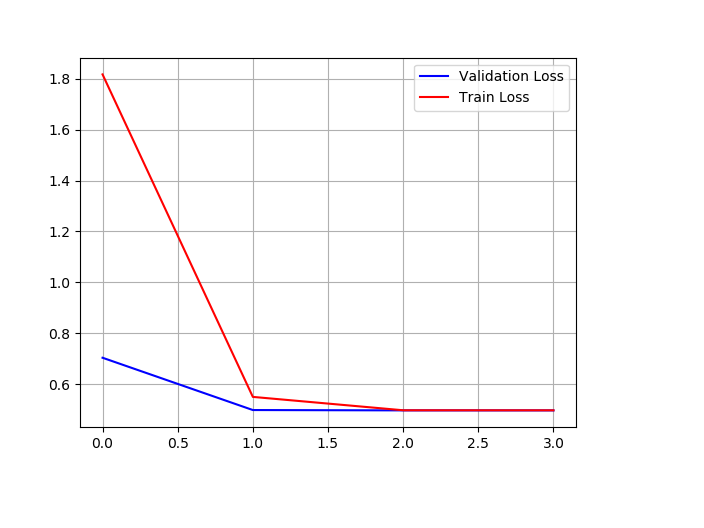

epoch: 1
2775 / 2775
77 / 77
Train loss: 1.817685933349369
Validation loss: 0.703453512160809
Validation error: 0.15679513
epoch: 2
2775 / 2775
77 / 77
Train loss: 0.5495200163609273
Validation loss: 0.4978260819788103
Validation error: 0.15679513
epoch: 3
2775 / 2775
77 / 77
Train loss: 0.4969166832464235
Validation loss: 0.49645704843781213
Validation error: 0.15679513
epoch: 4
2775 / 2775
77 / 77
Train loss: 0.4967390561533404
Validation loss: 0.49640976918208135
Validation error: 0.15679513
epoch: 5


In [ ]:
fig, ax = plt.subplots(1,1)
plt_dynamic([1,2], [1,2], [1,3], ax)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


summ = tf.summary.merge_all()
writer_tr = tf.summary.FileWriter('./logs/train')
writer_ts = tf.summary.FileWriter('./logs/val')
writer_tr.add_graph(sess.graph)

sess.run(tf.global_variables_initializer())

iter_train = iter_test = 0

for i in range(config['epoch']):
    print('epoch:',i+1)
    time.sleep(1)
    cc = 0
    
    # for training data
    for j in range(no_of_tr_batches):
        inp = X_train[j*config['batch_size']:(j+1)*config['batch_size']]
        out = y_train[j*config['batch_size']:(j+1)*config['batch_size']]
        _, c, s = sess.run([train_step, cost, summ], {data_x: inp, target: out})
        cc += c
        writer_tr.add_summary(s, iter_train)
        iter_train += 1
        print(f'{j+1} / {no_of_tr_batches}', end='\r')
    train_loss.append(cc/no_of_tr_batches)
    print('')
    
    # for validation data
    cc = 0
    for j in range(no_of_ts_batches):
        inp = X_test[j*config['batch_size']:(j+1)*config['batch_size']]
        out = y_test[j*config['batch_size']:(j+1)*config['batch_size']]
        c, s = sess.run([cost, summ], {data_x: inp, target: out})
        writer_ts.add_summary(s, iter_test)
        iter_test += 1
        cc += c
        print(f'{j+1} / {no_of_ts_batches}', end='\r')
    test_loss.append(cc/no_of_ts_batches)
    print('')
    
    print('Train loss:', train_loss[-1])
    print('Validation loss:', test_loss[-1])
    print('Validation error:', sess.run(error, {data_x: X_test, target: y_test}))
    print('='*40)
    plt_dynamic(range(i+1), test_loss, train_loss, ax)